In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import os
from IPython.display import display
import time
from math import log
t = time.time()

Nous étudions dans ce notebook un modèle **semi-supervisé** utilisant le modèle **Naive Bayes**.

# 1. Chargement de la base Sentiment140 et de la base webscrapée

## 1.1. Base Sentiment140

In [2]:
NB_DATA_140 = 200000
NB_DATA_WEB = 50

In [3]:
STOP_WORDS = False
LEMMATIZATION = False
NEGATION = False
file = "train"
if STOP_WORDS:
    file += "_stop"
if LEMMATIZATION:
    file += "_lemm"
if NEGATION:
    file += "_neg"
df_140 = pd.read_pickle(os.path.join("data", "sentiment140", file + ".bz2")).sample(NB_DATA_140, random_state=1234).reset_index(drop=True)
df_140.shape

(200000, 6)

In [4]:
df_140.head(10)

,sentiment,id,date,query_string,user,text
0,Negative,2220663113,Thu Jun 18 03:39:49 PDT 2009,NO_QUERY,gemgembam,open itunes will not open naooo the silence is...
1,Negative,2202759103,Tue Jun 16 22:21:43 PDT 2009,NO_QUERY,twistofcolour,the sun is already gone for the day
2,Positive,2049441111,Fri Jun 05 16:53:10 PDT 2009,NO_QUERY,Niico1e,hiya this is my st tweet i am so tired though ...
3,Negative,2204830292,Wed Jun 17 03:14:38 PDT 2009,NO_QUERY,MeriEsteban,i have the bac today at p m i do not know if i...
4,Positive,2190306594,Tue Jun 16 02:21:03 PDT 2009,NO_QUERY,MeghanMagnolia,as far as i remember you were not half bad ine...
5,Positive,2046706853,Fri Jun 05 12:34:26 PDT 2009,NO_QUERY,WahooPooh,as tempting as that is i am just waiting on my...
6,Negative,2215937155,Wed Jun 17 18:49:10 PDT 2009,NO_QUERY,amandarie,cool how i have to be stuck at home i want to ...
7,Positive,1676343245,Fri May 01 21:46:07 PDT 2009,NO_QUERY,MatchesMalone,oh and followfriday my writing partner because...
8,Negative,2192486836,Tue Jun 16 07:06:35 PDT 2009,NO_QUERY,hockeyfan45214,you would think if i continue to block someone...
9,Negative,1981647618,Sun May 31 09:35:54 PDT 2009,NO_QUERY,ilovemytroops,nevaeh buchanan missing friends of her mother ...


 ## 1.2. Base webscrapée

In [5]:
file = "web"
if STOP_WORDS:
    file += "_stop"
if LEMMATIZATION:
    file += "_lemm"
if NEGATION:
    file += "_neg"
df_web = pd.read_pickle(os.path.join("data", "web", file + ".bz2")).sample(NB_DATA_WEB, random_state=1234).reset_index(drop=True)
df_web.shape

(50, 7)

In [6]:
df_web.head(10)

,search,author,time,url,text,lang,reply
0,trump,Tea Pain,2019-12-27 23:48:11,/TeaPainUSA/status/1210708987143954437,weak and whiney,en,False
1,trump,Lincoln17 😊✌🌊❤🗽🌏🌈🎶,2019-09-30 23:58:44,/Lincoln1710/status/1178821513249775616,reality winner a whistleblower alerted the med...,en,False
2,biden,Eric Darcman,2019-09-08 23:06:58,/Darcman/status/1170835953067466753,poc will decide who the nominee is in the plac...,en,False
3,biden,"Joe Pizza's Accountant, Shlomi Matzoball 🔥",2019-12-27 22:57:05,/rev_avocado/status/1210696130440224768,but you know i am sure the hundredth joke abou...,en,False
4,trump,Make Integrity Great Again [Drapeau des États-...,2019-05-20 23:58:57,/CinnamonHH/status/1130623980434546690,i have had heat exhaustion and it is awful why...,en,False
5,trump,James S,2019-08-16 23:55:49,/JAlford1493/status/1162513323604111360,they just know how the movie ends they ed stil...,en,False
6,trump,#CountEveryVote Debrianna📢,2019-10-07 23:59:54,/DMansini/status/1181358518923743233,has it become completely obvious yet that this...,en,False
7,biden,doncalloway,2019-10-22 23:30:54,/dcstl/status/1186787039838003201,there is a very good chance that joe biden wil...,en,False
8,biden,ᎠᏌNᎬᎷYᎢᎻᎪNᏩ™️,2019-02-10 23:25:56,/Kris_Sacrebleu/status/1094739271703965696,i see a few candidates making some missteps ou...,en,False
9,trump,Charles Nutter,2019-01-08 23:56:39,/headius/status/1082788202853875712,this is the anger and hate politics you suppor...,en,False


## 1.3. Catégorisation à la main

In [7]:
from google_trans_new import google_translator  
  
translator = google_translator()  
translate_text = translator.translate("Hello my name is Bob", lang_tgt='fr')  
print(translate_text)

Bonjour, mon nom est Bob 


In [8]:
# %%time
# temp = df_web.copy()
# temp['text_trad'] = temp.text.map(lambda x: translator.translate(x, lang_tgt='fr'))
# temp.head(10)

In [9]:
# temp['sentiment'] = 0

In [10]:
# temp.to_excel(os.path.join("data", "web", "cat.xlsx"))

In [11]:
df_web_cat = pd.read_excel(os.path.join("data", "web", "cat_.xlsx")).drop(columns=['Unnamed: 0', 'text_trad'])
df_web_cat.sentiment = df_web_cat.sentiment.apply(lambda x: 'Negative' if x == 0 else 'Positive')
df_web_cat.head(10)

,search,author,time,url,text,lang,reply,sentiment
0,trump,Tea Pain,2019-12-27 23:48:11,/TeaPainUSA/status/1210708987143954437,weak and whiney,en,False,Negative
1,trump,Lincoln17 😊✌🌊❤🗽🌏🌈🎶,2019-09-30 23:58:44,/Lincoln1710/status/1178821513249775616,reality winner a whistleblower alerted the med...,en,False,Negative
2,biden,Eric Darcman,2019-09-08 23:06:58,/Darcman/status/1170835953067466753,poc will decide who the nominee is in the plac...,en,False,Negative
3,biden,"Joe Pizza's Accountant, Shlomi Matzoball 🔥",2019-12-27 22:57:05,/rev_avocado/status/1210696130440224768,but you know i am sure the hundredth joke abou...,en,False,Negative
4,trump,Make Integrity Great Again [Drapeau des États-...,2019-05-20 23:58:57,/CinnamonHH/status/1130623980434546690,i have had heat exhaustion and it is awful why...,en,False,Negative
5,trump,James S,2019-08-16 23:55:49,/JAlford1493/status/1162513323604111360,they just know how the movie ends they ed stil...,en,False,Negative
6,trump,#CountEveryVote Debrianna📢,2019-10-07 23:59:54,/DMansini/status/1181358518923743233,has it become completely obvious yet that this...,en,False,Negative
7,biden,doncalloway,2019-10-22 23:30:54,/dcstl/status/1186787039838003201,there is a very good chance that joe biden wil...,en,False,Positive
8,biden,ᎠᏌNᎬᎷYᎢᎻᎪNᏩ™️,2019-02-10 23:25:56,/Kris_Sacrebleu/status/1094739271703965696,i see a few candidates making some missteps ou...,en,False,Positive
9,trump,Charles Nutter,2019-01-08 23:56:39,/headius/status/1082788202853875712,this is the anger and hate politics you suppor...,en,False,Negative


In [12]:
(df_web_cat.text == df_web.text).all()

True

In [13]:
df_web['sentiment'] = df_web_cat.sentiment
df_web.head(10)

,search,author,time,url,text,lang,reply,sentiment
0,trump,Tea Pain,2019-12-27 23:48:11,/TeaPainUSA/status/1210708987143954437,weak and whiney,en,False,Negative
1,trump,Lincoln17 😊✌🌊❤🗽🌏🌈🎶,2019-09-30 23:58:44,/Lincoln1710/status/1178821513249775616,reality winner a whistleblower alerted the med...,en,False,Negative
2,biden,Eric Darcman,2019-09-08 23:06:58,/Darcman/status/1170835953067466753,poc will decide who the nominee is in the plac...,en,False,Negative
3,biden,"Joe Pizza's Accountant, Shlomi Matzoball 🔥",2019-12-27 22:57:05,/rev_avocado/status/1210696130440224768,but you know i am sure the hundredth joke abou...,en,False,Negative
4,trump,Make Integrity Great Again [Drapeau des États-...,2019-05-20 23:58:57,/CinnamonHH/status/1130623980434546690,i have had heat exhaustion and it is awful why...,en,False,Negative
5,trump,James S,2019-08-16 23:55:49,/JAlford1493/status/1162513323604111360,they just know how the movie ends they ed stil...,en,False,Negative
6,trump,#CountEveryVote Debrianna📢,2019-10-07 23:59:54,/DMansini/status/1181358518923743233,has it become completely obvious yet that this...,en,False,Negative
7,biden,doncalloway,2019-10-22 23:30:54,/dcstl/status/1186787039838003201,there is a very good chance that joe biden wil...,en,False,Positive
8,biden,ᎠᏌNᎬᎷYᎢᎻᎪNᏩ™️,2019-02-10 23:25:56,/Kris_Sacrebleu/status/1094739271703965696,i see a few candidates making some missteps ou...,en,False,Positive
9,trump,Charles Nutter,2019-01-08 23:56:39,/headius/status/1082788202853875712,this is the anger and hate politics you suppor...,en,False,Negative


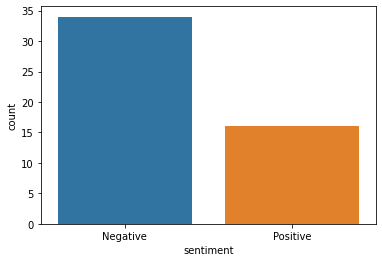

In [14]:
sns.countplot(x='sentiment', data=df_web)
plt.show()

In [15]:
X_140 = df_140.text.to_list()
y_140 = df_140.sentiment.to_list()
X_web = df_web.text.to_list()
y_web = df_web.sentiment.to_list()

# 2. Performances des modèles précédents

In [16]:
def conf_matrix(X_140, y_140, X_web, y_web, vectorizer, model, verbose=True):
    X_140 = vectorizer.fit_transform(X_140)
    X_train_140, X_test_140, y_train_140, y_test_140 = train_test_split(StandardScaler(with_mean=False).fit_transform(X_140), y_140, train_size=0.80, random_state=1234)
    
    model.fit(X_train_140, y_train_140)    
    y_pred_140 = model.predict(X_test_140)
    
    X_web = vectorizer.transform(X_web)
    y_pred_web = model.predict(X_web)
    
    for (X_test, y_test, y_pred) in [(X_test_140, y_test_140, y_pred_140), (X_web, y_web, y_pred_web)]:
        y_pred = model.predict(X_test)

        sc_accuracy = metrics.accuracy_score(y_pred, y_test)    
        sc_balanced_accuracy = metrics.balanced_accuracy_score(y_pred, y_test)
        sc_f1 = metrics.f1_score(y_pred, y_test, pos_label="Positive")
        sc_recall = metrics.recall_score(y_pred, y_test, pos_label="Positive")
        sc_precision = metrics.precision_score(y_pred, y_test, pos_label="Positive")
        sc_roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        probs = model.predict_proba(X_test)[:, 1]

        if verbose:
            metrics.plot_confusion_matrix(model, X_test, y_test)
            plt.show()

            print(f"Accuracy : {sc_accuracy:.4f}")
            print(f"Balanced accuracy : {sc_balanced_accuracy:.4f}")
        #     print(f"Recall : {sc_recall}")
        #     print(f"Precision : {sc_precision}")
        #     print(f"F1 : {sc_f1}")
            print(f"ROC AUC : {sc_roc_auc:.4f}")

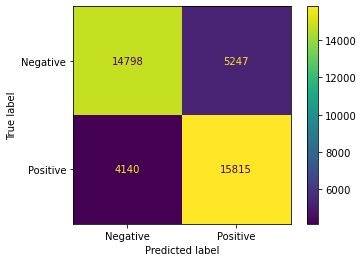

Accuracy : 0.7653
Balanced accuracy : 0.7661
ROC AUC : 0.8380


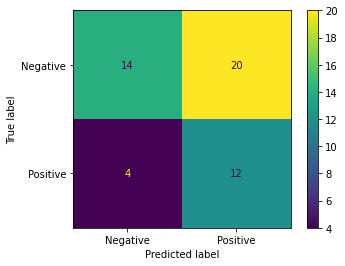

Accuracy : 0.5200
Balanced accuracy : 0.5764
ROC AUC : 0.4301
Wall time: 4.38 s


In [17]:
%%time
conf_matrix(X_140, y_140, X_web, y_web, CountVectorizer(max_features=1000), LogisticRegression())

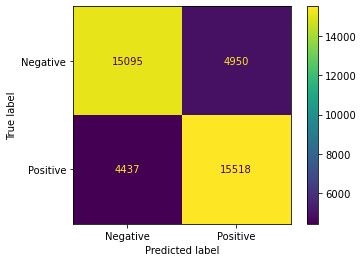

Accuracy : 0.7653
Balanced accuracy : 0.7655
ROC AUC : 0.8449


C:\Users\pasqu\anaconda3\envs\data-2A\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


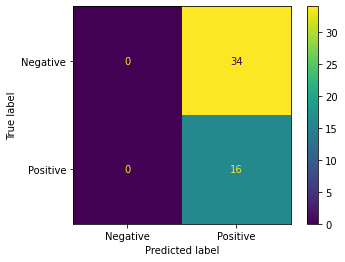

Accuracy : 0.3200
Balanced accuracy : 0.3200
ROC AUC : 0.4577
Wall time: 4.61 s


In [18]:
%%time
conf_matrix(X_140, y_140, X_web, y_web, TfidfVectorizer(max_features=1000), LogisticRegression())

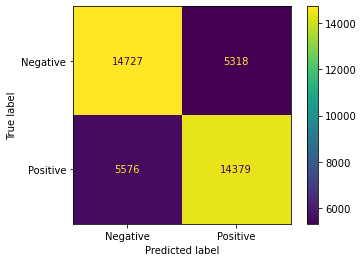

Accuracy : 0.7277
Balanced accuracy : 0.7277
ROC AUC : 0.7949


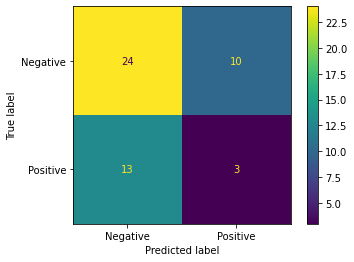

Accuracy : 0.5400
Balanced accuracy : 0.4397
ROC AUC : 0.5294
Wall time: 4.33 s


In [19]:
%%time
conf_matrix(X_140, y_140, X_web, y_web, CountVectorizer(max_features=1000), MultinomialNB(alpha=1))

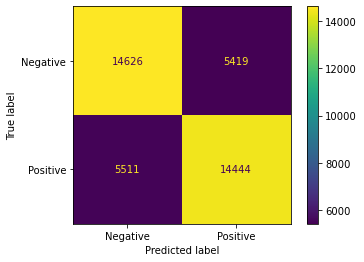

Accuracy : 0.7268
Balanced accuracy : 0.7268
ROC AUC : 0.8016


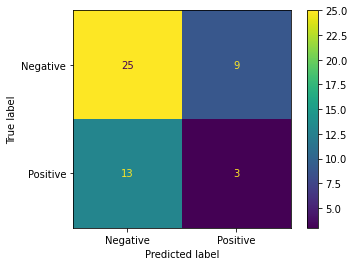

Accuracy : 0.5600
Balanced accuracy : 0.4539
ROC AUC : 0.5349
Wall time: 4.12 s


In [20]:
%%time
conf_matrix(X_140, y_140, X_web, y_web, TfidfVectorizer(max_features=1000), MultinomialNB(alpha=1))